<a href="https://colab.research.google.com/github/carlosnylander/TrabalhoML/blob/main/Testando_quartis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, GRU, SimpleRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# ETAPA 1: CARREGAMENTO E PREPARAÇÃO DOS DADOS
# -------------------------------------------------------------------------

data = pd.read_csv('/content/oficialtcld0903.csv')  # Atualize o caminho se necessário

X = data.drop(columns=['TCSacr','med10','sd10'])
y = data['bal75']



# Dividir os dados em treino (80%) e teste (20%)
# Usando a lógica de n_train para um split 80/20
split_percentage_train = 0.9
n_train = int(len(X) * split_percentage_train)

if n_train == 0 or n_train == len(X):
    print(f"Erro: Divisão de treino/teste resultou em um conjunto de treino ou teste vazio.")
    print(f"Total de amostras: {len(X)}, Amostras de treino calculadas (80%): {n_train}")
    exit()

X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]

print(f"\nDos {len(X)} dados selecionados para o processo:")
print(f" - {len(X_train)} amostras para treino ({split_percentage_train*100:.0f}%)")
print(f" - {len(X_test)} amostras para teste ({(1-split_percentage_train)*100:.0f}%)")

if X_train.empty or X_test.empty:
    print("Erro crítico: Conjuntos de treino ou teste estão vazios após a divisão. Verifique o tamanho dos dados.")
    exit()

# -------------------------------------------------------------------------
# ETAPA 2: DEFINIÇÃO DOS MODELOS
# -------------------------------------------------------------------------
def create_mlp_model(input_dim):
    model = Sequential([
        Dense(10, input_dim=input_dim, activation='relu'),
        Dense(5, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_cnn_model(input_dim):
    model = Sequential([
        Conv1D(10, 2, activation='relu', input_shape=(input_dim, 1)), # CNN espera entrada 3D
        Flatten(),
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_lstm_model(input_dim):
    model = Sequential([
        LSTM(10, input_shape=(input_dim, 1), activation='tanh'), # LSTM espera entrada 3D
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model(input_dim):
    model = Sequential([
        GRU(10, input_shape=(input_dim, 1), activation='tanh'), # GRU espera entrada 3D
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_rnn_model(input_dim):
    model = Sequential([
        SimpleRNN(10, input_shape=(input_dim, 1), activation='tanh'), # RNN espera entrada 3D
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# -------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE TREINAMENTO E AVALIAÇÃO
# -------------------------------------------------------------------------
def train_and_evaluate_model(model_name, model, X_train_data, y_train_data, X_test_data, y_test_data):
    print(f"\nTreinando e avaliando {model_name}...")

    # Reshape X_train e X_test para modelos que esperam entrada 3D (CNN, LSTM, GRU, RNN)
    # A entrada para esses modelos é geralmente (samples, timesteps, features)
    # Se as features já são sequenciais (ex: dados de janela), timesteps > 1.
    # Se cada linha é um timestep independente com múltiplas features, timesteps = 1.
    # Para este caso, assumimos que cada linha de X_train/X_test é uma amostra,
    # e as colunas são features. Para CNN/LSTM/GRU/RNN, trataremos cada amostra como um único timestep.
    # input_dim será o número de features.

    if model_name in ['CNN', 'LSTM', 'GRU', 'RNN']:
        # Converte para NumPy array se for DataFrame Pandas
        X_train_vals = X_train_data.values if isinstance(X_train_data, pd.DataFrame) else X_train_data
        X_test_vals = X_test_data.values if isinstance(X_test_data, pd.DataFrame) else X_test_data

        # Reshape para (samples, features, 1) - comum para Conv1D se features são canais
        # Ou (samples, 1, features) - se tratando cada amostra como 1 timestep e N features
        # A definição do modelo usa input_shape=(input_dim, 1), o que implica (timesteps=num_features, channels=1)
        # ou (timesteps=num_columns_of_X, 1 feature_channel_per_timestep)
        # Se input_dim é X_train.shape[1] (número de features), então o reshape deve ser (samples, num_features, 1)
        X_train_r = np.expand_dims(X_train_vals, axis=2)
        X_test_r = np.expand_dims(X_test_vals, axis=2)

        history = model.fit(X_train_r, y_train_data, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
        y_pred = model.predict(X_test_r, verbose=0).flatten()
    else: # MLP
        history = model.fit(X_train_data, y_train_data, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
        y_pred = model.predict(X_test_data, verbose=0).flatten()

    mae = mean_absolute_error(y_test_data, y_pred)
    mse = mean_squared_error(y_test_data, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} Model - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    return y_pred, rmse

# -------------------------------------------------------------------------
# ETAPA 4: TREINAMENTO DOS MODELOS
# -------------------------------------------------------------------------
input_dimension = X_train.shape[1] # Número de features

mlp_model = create_mlp_model(input_dimension)
cnn_model = create_cnn_model(input_dimension) # input_dim aqui é o número de features
lstm_model = create_lstm_model(input_dimension)
gru_model = create_gru_model(input_dimension)
rnn_model = create_rnn_model(input_dimension)

print("\nIniciando treinamento e avaliação dos modelos...")

y_pred_mlp, _ = train_and_evaluate_model("MLP", mlp_model, X_train, y_train, X_test, y_test)
y_pred_cnn, _ = train_and_evaluate_model("CNN", cnn_model, X_train, y_train, X_test, y_test)
y_pred_lstm, _ = train_and_evaluate_model("LSTM", lstm_model, X_train, y_train, X_test, y_test)
y_pred_gru, _ = train_and_evaluate_model("GRU", gru_model, X_train, y_train, X_test, y_test)
y_pred_rnn, _ = train_and_evaluate_model("RNN", rnn_model, X_train, y_train, X_test, y_test)

print("\nTreinamento e avaliação concluídos.")

# Coletar resultados para plotagem
results_for_plotting = {
    "MLP": y_pred_mlp,
    "CNN": y_pred_cnn,
    "LSTM": y_pred_lstm,
    "GRU": y_pred_gru,
    "RNN": y_pred_rnn
}
can_plot = True # Assumindo que o treinamento ocorreu e temos resultados

# -------------------------------------------------------------------------
# ETAPA 5: FUNÇÕES DE PLOTAGEM E EXECUÇÃO
# -------------------------------------------------------------------------

def smooth_series(series, window_size=1): # Default da função, mas a plotagem usa seu próprio parâmetro
    """Aplica suavização de média móvel a uma série."""
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(window=window_size, min_periods=1, center=True).mean().values

def plot_real_vs_predito_com_incerteza_subplots(
    results_dict,
    y_test_data, # Espera pd.Series ou array NumPy
    num_points_to_plot=500,
    scale_factor=1.0,
    smoothing_window=15, # Janela de suavização para a faixa
    enable_smoothing=True,
    pred_line_color='red',
    real_line_color='blue',
    interval_fill_color='gray',
    interval_alpha=0.4
):
    model_names = list(results_dict.keys())
    num_models = len(model_names)

    if num_models == 0:
        print("Nenhum resultado de modelo para plotar em 'Real vs Predito'.")
        return

    if isinstance(y_test_data, pd.Series):
        y_test_np = y_test_data.values
    elif isinstance(y_test_data, list):
        y_test_np = np.array(y_test_data)
    else:
        y_test_np = y_test_data

    actual_points_to_plot = min(num_points_to_plot, len(y_test_np))
    y_test_plot_slice = y_test_np[:actual_points_to_plot]
    indices = np.arange(actual_points_to_plot)

    fig, axs = plt.subplots(num_models, 1, figsize=(12, 4 * num_models), sharex=True, sharey=True)
    if num_models == 1:
        axs = [axs]

    print(f"\n🔎 Gerando gráficos de Real vs. Predito com Faixa de Incerteza (Subplots)...")

    for i, model_name in enumerate(model_names):
        ax = axs[i]

        all_model_predictions = results_dict[model_name]
        if isinstance(all_model_predictions, pd.Series):
            all_model_predictions_np = all_model_predictions.values
        elif isinstance(all_model_predictions, list):
            all_model_predictions_np = np.array(all_model_predictions)
        else:
            all_model_predictions_np = all_model_predictions

        predictions_plot_slice = all_model_predictions_np[:actual_points_to_plot]

        pred_std_dev = np.std(all_model_predictions_np)

        half_interval_width = scale_factor * pred_std_dev
        print(f"  Informações da Faixa para o Modelo: {model_name}")
        print(f"    - Desvio Padrão das Predições (σ) em todo o conjunto de teste: {pred_std_dev:.2f}")
        print(f"    - Largura da Faixa (valor ± em relação à predição): {half_interval_width:.2f} (correspondente a {scale_factor:.1f}σ)")

        lower_bound = predictions_plot_slice - half_interval_width
        upper_bound = predictions_plot_slice + half_interval_width

        if enable_smoothing and smoothing_window > 1:
            lower_bound_smooth = smooth_series(lower_bound.flatten(), window_size=smoothing_window)
            upper_bound_smooth = smooth_series(upper_bound.flatten(), window_size=smoothing_window)
        else:
            lower_bound_smooth = lower_bound.flatten()
            upper_bound_smooth = upper_bound.flatten()

        ax.plot(indices, y_test_plot_slice, color=real_line_color, label='Real', linewidth=1.5, zorder=3)
        ax.plot(indices, predictions_plot_slice, color=pred_line_color, label=f'Predito {model_name}', linewidth=1.5, linestyle='--', zorder=2)
        ax.fill_between(
            indices, lower_bound_smooth, upper_bound_smooth,
            color=interval_fill_color, alpha=interval_alpha,
            label=f'Faixa Incerteza (Pred. ± {scale_factor:.1f}σ)', zorder=1
        )
        ax.set_title(f'{model_name}: Real vs Predito com Faixa de Incerteza', fontsize=14)
        ax.set_ylabel('Valor', fontsize=12)
        if i == num_models - 1:
            ax.set_xlabel('Índice de Amostra no Conjunto de Teste', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()
    print("\nGráficos de Real vs Predito gerados.")

# Executar a plotagem se o treinamento ocorreu e y_test está disponível
if can_plot and 'y_test' in locals() and not y_test.empty:
    plot_real_vs_predito_com_incerteza_subplots(
        results_dict=results_for_plotting,
        y_test_data=y_test,
        num_points_to_plot=500,
        scale_factor=1.0,
        interval_fill_color='darkgray',
        interval_alpha=0.8, # Usando o alpha original da sua chamada para "faixa mais escura"
        enable_smoothing=True,
        smoothing_window=15
    )
elif not can_plot:
    print("\nPlotagem não realizada porque o treinamento dos modelos foi pulado ou falhou.")
else:
    print("\nPlotagem não realizada porque 'y_test' não está definido ou está vazio.")




Dos 77902 dados selecionados para o processo:
 - 70111 amostras para treino (90%)
 - 7791 amostras para teste (10%)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Iniciando treinamento e avaliação dos modelos...

Treinando e avaliando MLP...


KeyboardInterrupt: 


Dos 38953 dados selecionados para o processo:
 - 35057 amostras para treino (90%)
 - 3896 amostras para teste (10%)

Iniciando treinamento e avaliação dos modelos...

Treinando e avaliando MLP...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MLP Model - MAE: 0.0666, MSE: 0.0047, RMSE: 0.0686

Treinando e avaliando CNN...
CNN Model - MAE: 0.2953, MSE: 0.0890, RMSE: 0.2983

Treinando e avaliando LSTM...
LSTM Model - MAE: 74.2022, MSE: 7747.5706, RMSE: 88.0203

Treinando e avaliando GRU...
GRU Model - MAE: 215.8545, MSE: 59200.8192, RMSE: 243.3122

Treinando e avaliando RNN...
RNN Model - MAE: 216.2332, MSE: 59505.2148, RMSE: 243.9369

Treinamento e avaliação concluídos.

🔎 Gerando gráficos de Real vs. Predito com Faixa de Incerteza (Subplots)...
  Informações da Faixa para o Modelo: MLP
    - Desvio Padrão das Predições (σ) em todo o conjunto de teste: 234.35
    - Largura da Faixa (valor ± em relação à predição): 234.35 (correspondente a 1.0σ)
  Informações da Faixa para o Modelo: CNN
    - Desvio Padrão das Predições (σ) em todo o conjunto de teste: 234.40
    - Largura da Faixa (valor ± em relação à predição): 234.40 (correspondente a 1.0σ)
  Informações da Faixa para o Modelo: LSTM
    - Desvio Padrão das Predições (σ) e

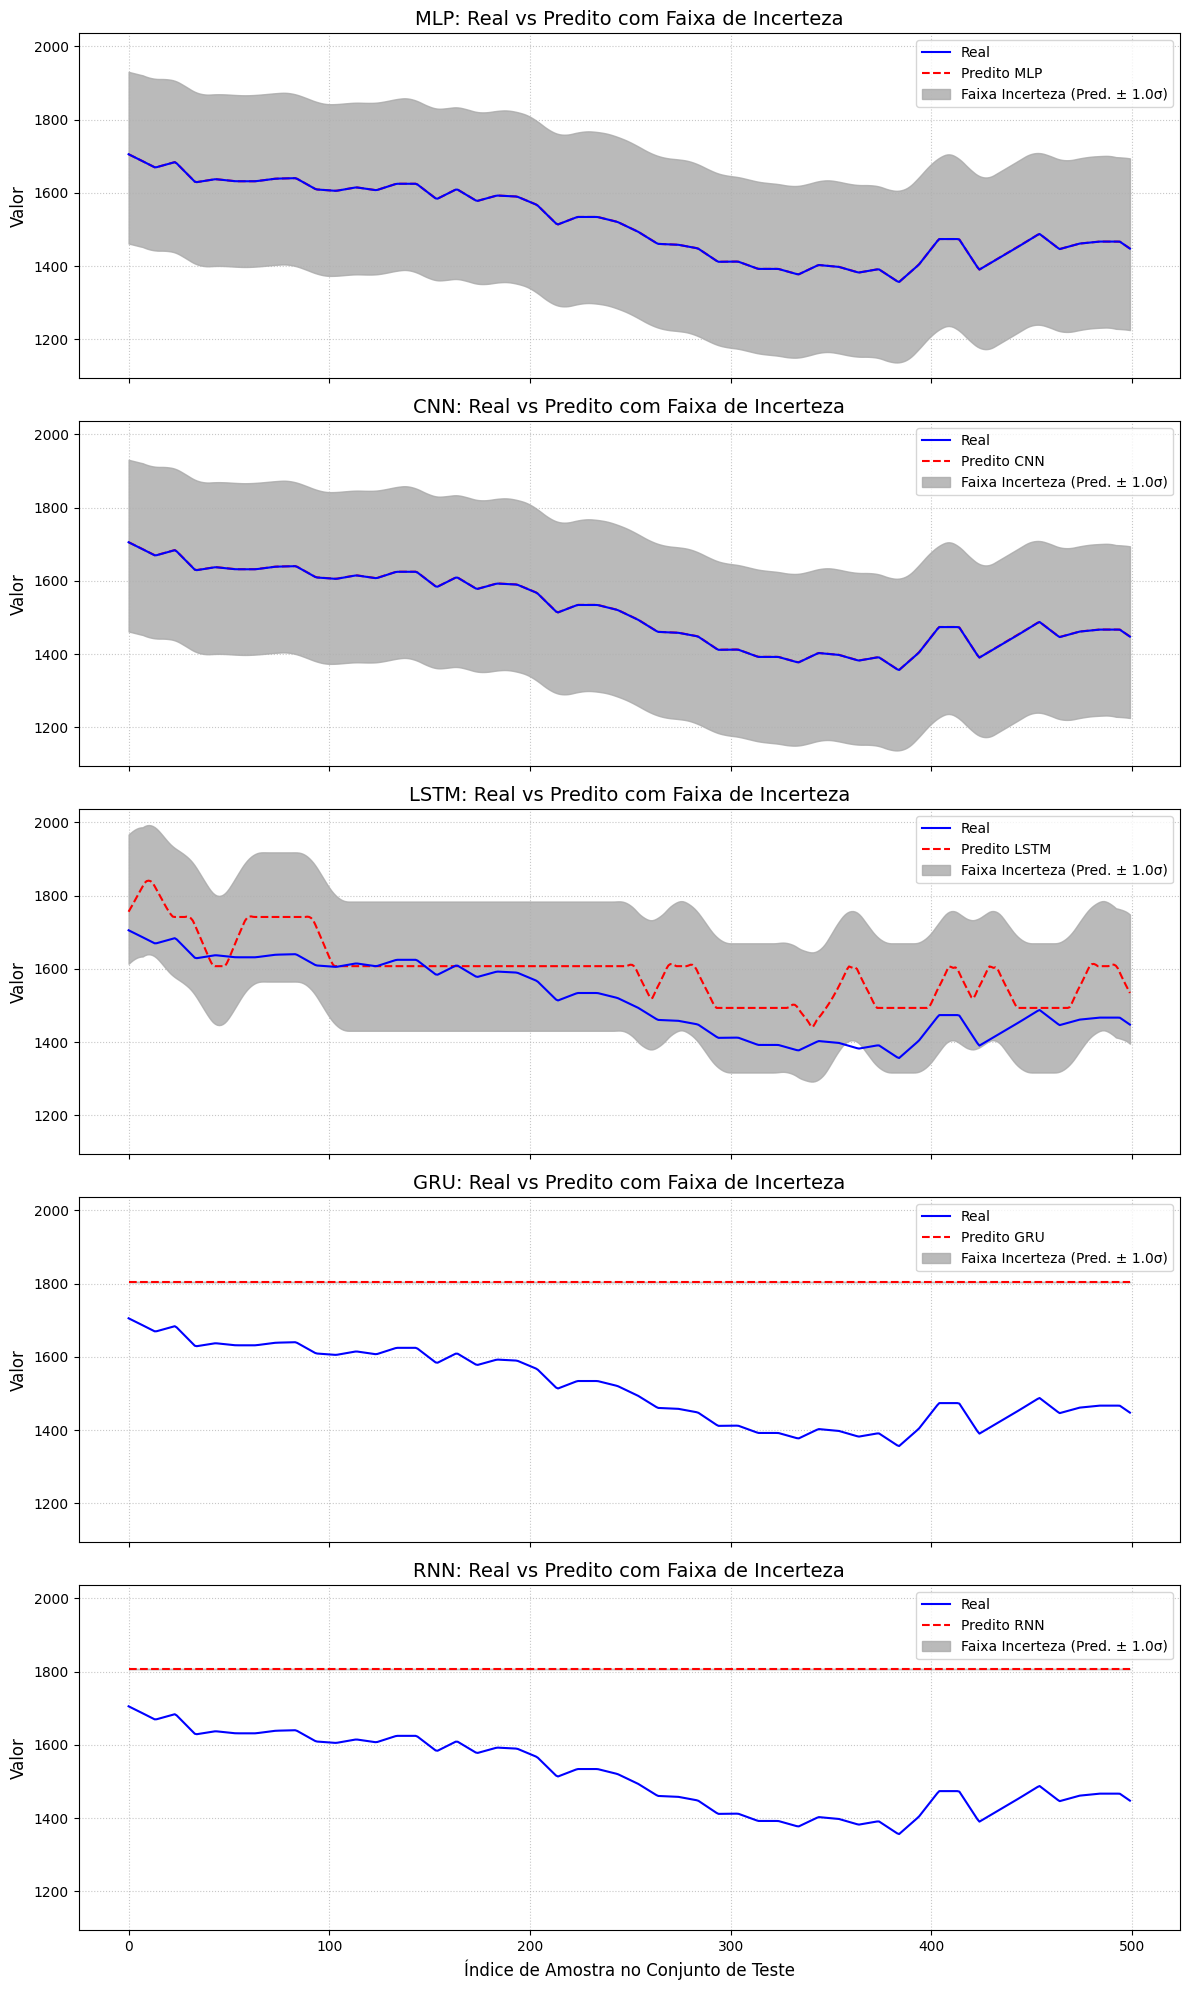


Gráficos de Real vs Predito gerados.


In [8]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, GRU, SimpleRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# ETAPA 1: CARREGAMENTO E PREPARAÇÃO DOS DADOS
# -------------------------------------------------------------------------

data = pd.read_csv('/content/Bal75_50porcento.csv')  # Atualize o caminho se necessário

X = data.drop(columns=['med10','sd10'])
y = data['bal75']



# Dividir os dados em treino (80%) e teste (20%)
# Usando a lógica de n_train para um split 80/20
split_percentage_train = 0.9
n_train = int(len(X) * split_percentage_train)

if n_train == 0 or n_train == len(X):
    print(f"Erro: Divisão de treino/teste resultou em um conjunto de treino ou teste vazio.")
    print(f"Total de amostras: {len(X)}, Amostras de treino calculadas (80%): {n_train}")
    exit()

X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]

print(f"\nDos {len(X)} dados selecionados para o processo:")
print(f" - {len(X_train)} amostras para treino ({split_percentage_train*100:.0f}%)")
print(f" - {len(X_test)} amostras para teste ({(1-split_percentage_train)*100:.0f}%)")

if X_train.empty or X_test.empty:
    print("Erro crítico: Conjuntos de treino ou teste estão vazios após a divisão. Verifique o tamanho dos dados.")
    exit()

# -------------------------------------------------------------------------
# ETAPA 2: DEFINIÇÃO DOS MODELOS
# -------------------------------------------------------------------------
def create_mlp_model(input_dim):
    model = Sequential([
        Dense(10, input_dim=input_dim, activation='relu'),
        Dense(5, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_cnn_model(input_dim):
    model = Sequential([
        Conv1D(10, 2, activation='relu', input_shape=(input_dim, 1)), # CNN espera entrada 3D
        Flatten(),
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_lstm_model(input_dim):
    model = Sequential([
        LSTM(10, input_shape=(input_dim, 1), activation='tanh'), # LSTM espera entrada 3D
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model(input_dim):
    model = Sequential([
        GRU(10, input_shape=(input_dim, 1), activation='tanh'), # GRU espera entrada 3D
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_rnn_model(input_dim):
    model = Sequential([
        SimpleRNN(10, input_shape=(input_dim, 1), activation='tanh'), # RNN espera entrada 3D
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# -------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE TREINAMENTO E AVALIAÇÃO
# -------------------------------------------------------------------------
def train_and_evaluate_model(model_name, model, X_train_data, y_train_data, X_test_data, y_test_data):
    print(f"\nTreinando e avaliando {model_name}...")

    # Reshape X_train e X_test para modelos que esperam entrada 3D (CNN, LSTM, GRU, RNN)
    # A entrada para esses modelos é geralmente (samples, timesteps, features)
    # Se as features já são sequenciais (ex: dados de janela), timesteps > 1.
    # Se cada linha é um timestep independente com múltiplas features, timesteps = 1.
    # Para este caso, assumimos que cada linha de X_train/X_test é uma amostra,
    # e as colunas são features. Para CNN/LSTM/GRU/RNN, trataremos cada amostra como um único timestep.
    # input_dim será o número de features.

    if model_name in ['CNN', 'LSTM', 'GRU', 'RNN']:
        # Converte para NumPy array se for DataFrame Pandas
        X_train_vals = X_train_data.values if isinstance(X_train_data, pd.DataFrame) else X_train_data
        X_test_vals = X_test_data.values if isinstance(X_test_data, pd.DataFrame) else X_test_data

        # Reshape para (samples, features, 1) - comum para Conv1D se features são canais
        # Ou (samples, 1, features) - se tratando cada amostra como 1 timestep e N features
        # A definição do modelo usa input_shape=(input_dim, 1), o que implica (timesteps=num_features, channels=1)
        # ou (timesteps=num_columns_of_X, 1 feature_channel_per_timestep)
        # Se input_dim é X_train.shape[1] (número de features), então o reshape deve ser (samples, num_features, 1)
        X_train_r = np.expand_dims(X_train_vals, axis=2)
        X_test_r = np.expand_dims(X_test_vals, axis=2)

        history = model.fit(X_train_r, y_train_data, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
        y_pred = model.predict(X_test_r, verbose=0).flatten()
    else: # MLP
        history = model.fit(X_train_data, y_train_data, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
        y_pred = model.predict(X_test_data, verbose=0).flatten()

    mae = mean_absolute_error(y_test_data, y_pred)
    mse = mean_squared_error(y_test_data, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} Model - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    return y_pred, rmse

# -------------------------------------------------------------------------
# ETAPA 4: TREINAMENTO DOS MODELOS
# -------------------------------------------------------------------------
input_dimension = X_train.shape[1] # Número de features

mlp_model = create_mlp_model(input_dimension)
cnn_model = create_cnn_model(input_dimension) # input_dim aqui é o número de features
lstm_model = create_lstm_model(input_dimension)
gru_model = create_gru_model(input_dimension)
rnn_model = create_rnn_model(input_dimension)

print("\nIniciando treinamento e avaliação dos modelos...")

y_pred_mlp, _ = train_and_evaluate_model("MLP", mlp_model, X_train, y_train, X_test, y_test)
y_pred_cnn, _ = train_and_evaluate_model("CNN", cnn_model, X_train, y_train, X_test, y_test)
y_pred_lstm, _ = train_and_evaluate_model("LSTM", lstm_model, X_train, y_train, X_test, y_test)
y_pred_gru, _ = train_and_evaluate_model("GRU", gru_model, X_train, y_train, X_test, y_test)
y_pred_rnn, _ = train_and_evaluate_model("RNN", rnn_model, X_train, y_train, X_test, y_test)

print("\nTreinamento e avaliação concluídos.")

# Coletar resultados para plotagem
results_for_plotting = {
    "MLP": y_pred_mlp,
    "CNN": y_pred_cnn,
    "LSTM": y_pred_lstm,
    "GRU": y_pred_gru,
    "RNN": y_pred_rnn
}
can_plot = True # Assumindo que o treinamento ocorreu e temos resultados

# -------------------------------------------------------------------------
# ETAPA 5: FUNÇÕES DE PLOTAGEM E EXECUÇÃO
# -------------------------------------------------------------------------

def smooth_series(series, window_size=1): # Default da função, mas a plotagem usa seu próprio parâmetro
    """Aplica suavização de média móvel a uma série."""
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(window=window_size, min_periods=1, center=True).mean().values

def plot_real_vs_predito_com_incerteza_subplots(
    results_dict,
    y_test_data, # Espera pd.Series ou array NumPy
    num_points_to_plot=500,
    scale_factor=1.0,
    smoothing_window=15, # Janela de suavização para a faixa
    enable_smoothing=True,
    pred_line_color='red',
    real_line_color='blue',
    interval_fill_color='gray',
    interval_alpha=0.4
):
    model_names = list(results_dict.keys())
    num_models = len(model_names)

    if num_models == 0:
        print("Nenhum resultado de modelo para plotar em 'Real vs Predito'.")
        return

    if isinstance(y_test_data, pd.Series):
        y_test_np = y_test_data.values
    elif isinstance(y_test_data, list):
        y_test_np = np.array(y_test_data)
    else:
        y_test_np = y_test_data

    actual_points_to_plot = min(num_points_to_plot, len(y_test_np))
    y_test_plot_slice = y_test_np[:actual_points_to_plot]
    indices = np.arange(actual_points_to_plot)

    fig, axs = plt.subplots(num_models, 1, figsize=(12, 4 * num_models), sharex=True, sharey=True)
    if num_models == 1:
        axs = [axs]

    print(f"\n🔎 Gerando gráficos de Real vs. Predito com Faixa de Incerteza (Subplots)...")

    for i, model_name in enumerate(model_names):
        ax = axs[i]

        all_model_predictions = results_dict[model_name]
        if isinstance(all_model_predictions, pd.Series):
            all_model_predictions_np = all_model_predictions.values
        elif isinstance(all_model_predictions, list):
            all_model_predictions_np = np.array(all_model_predictions)
        else:
            all_model_predictions_np = all_model_predictions

        predictions_plot_slice = all_model_predictions_np[:actual_points_to_plot]

        pred_std_dev = np.std(all_model_predictions_np)

        half_interval_width = scale_factor * pred_std_dev
        print(f"  Informações da Faixa para o Modelo: {model_name}")
        print(f"    - Desvio Padrão das Predições (σ) em todo o conjunto de teste: {pred_std_dev:.2f}")
        print(f"    - Largura da Faixa (valor ± em relação à predição): {half_interval_width:.2f} (correspondente a {scale_factor:.1f}σ)")

        lower_bound = predictions_plot_slice - half_interval_width
        upper_bound = predictions_plot_slice + half_interval_width

        if enable_smoothing and smoothing_window > 1:
            lower_bound_smooth = smooth_series(lower_bound.flatten(), window_size=smoothing_window)
            upper_bound_smooth = smooth_series(upper_bound.flatten(), window_size=smoothing_window)
        else:
            lower_bound_smooth = lower_bound.flatten()
            upper_bound_smooth = upper_bound.flatten()

        ax.plot(indices, y_test_plot_slice, color=real_line_color, label='Real', linewidth=1.5, zorder=3)
        ax.plot(indices, predictions_plot_slice, color=pred_line_color, label=f'Predito {model_name}', linewidth=1.5, linestyle='--', zorder=2)
        ax.fill_between(
            indices, lower_bound_smooth, upper_bound_smooth,
            color=interval_fill_color, alpha=interval_alpha,
            label=f'Faixa Incerteza (Pred. ± {scale_factor:.1f}σ)', zorder=1
        )
        ax.set_title(f'{model_name}: Real vs Predito com Faixa de Incerteza', fontsize=14)
        ax.set_ylabel('Valor', fontsize=12)
        if i == num_models - 1:
            ax.set_xlabel('Índice de Amostra no Conjunto de Teste', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()
    print("\nGráficos de Real vs Predito gerados.")

# Executar a plotagem se o treinamento ocorreu e y_test está disponível
if can_plot and 'y_test' in locals() and not y_test.empty:
    plot_real_vs_predito_com_incerteza_subplots(
        results_dict=results_for_plotting,
        y_test_data=y_test,
        num_points_to_plot=500,
        scale_factor=1.0,
        interval_fill_color='darkgray',
        interval_alpha=0.8, # Usando o alpha original da sua chamada para "faixa mais escura"
        enable_smoothing=True,
        smoothing_window=15
    )
elif not can_plot:
    print("\nPlotagem não realizada porque o treinamento dos modelos foi pulado ou falhou.")
else:
    print("\nPlotagem não realizada porque 'y_test' não está definido ou está vazio.")



Dataset original com 77902 linhas.
Utilizando 15580 linhas (20% do original) para o processo de treino e teste.
Dos 15580 dados selecionados para o processo:
 - 10906 amostras para treino (70%)
 - 4674 amostras para teste (30%)

Iniciando treinamento e avaliação dos modelos com 60% do dataset original...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MLP Model - MAE: 0.5477, MSE: 0.3056, RMSE: 0.5528
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CNN Model - MAE: 0.0398, MSE: 0.0029, RMSE: 0.0536
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Model - MAE: 68.0981, MSE: 7820.9019, RMSE: 88.4359
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
GRU Model - MAE: 58.6578, MSE: 5811.4688, RMSE: 76.2330
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RNN Model - MAE: 134.6400, MSE: 26722.8141, RMSE: 163.4711

Treinamento e avaliação concluídos.

Gerando gráficos de Real vs. Predito...


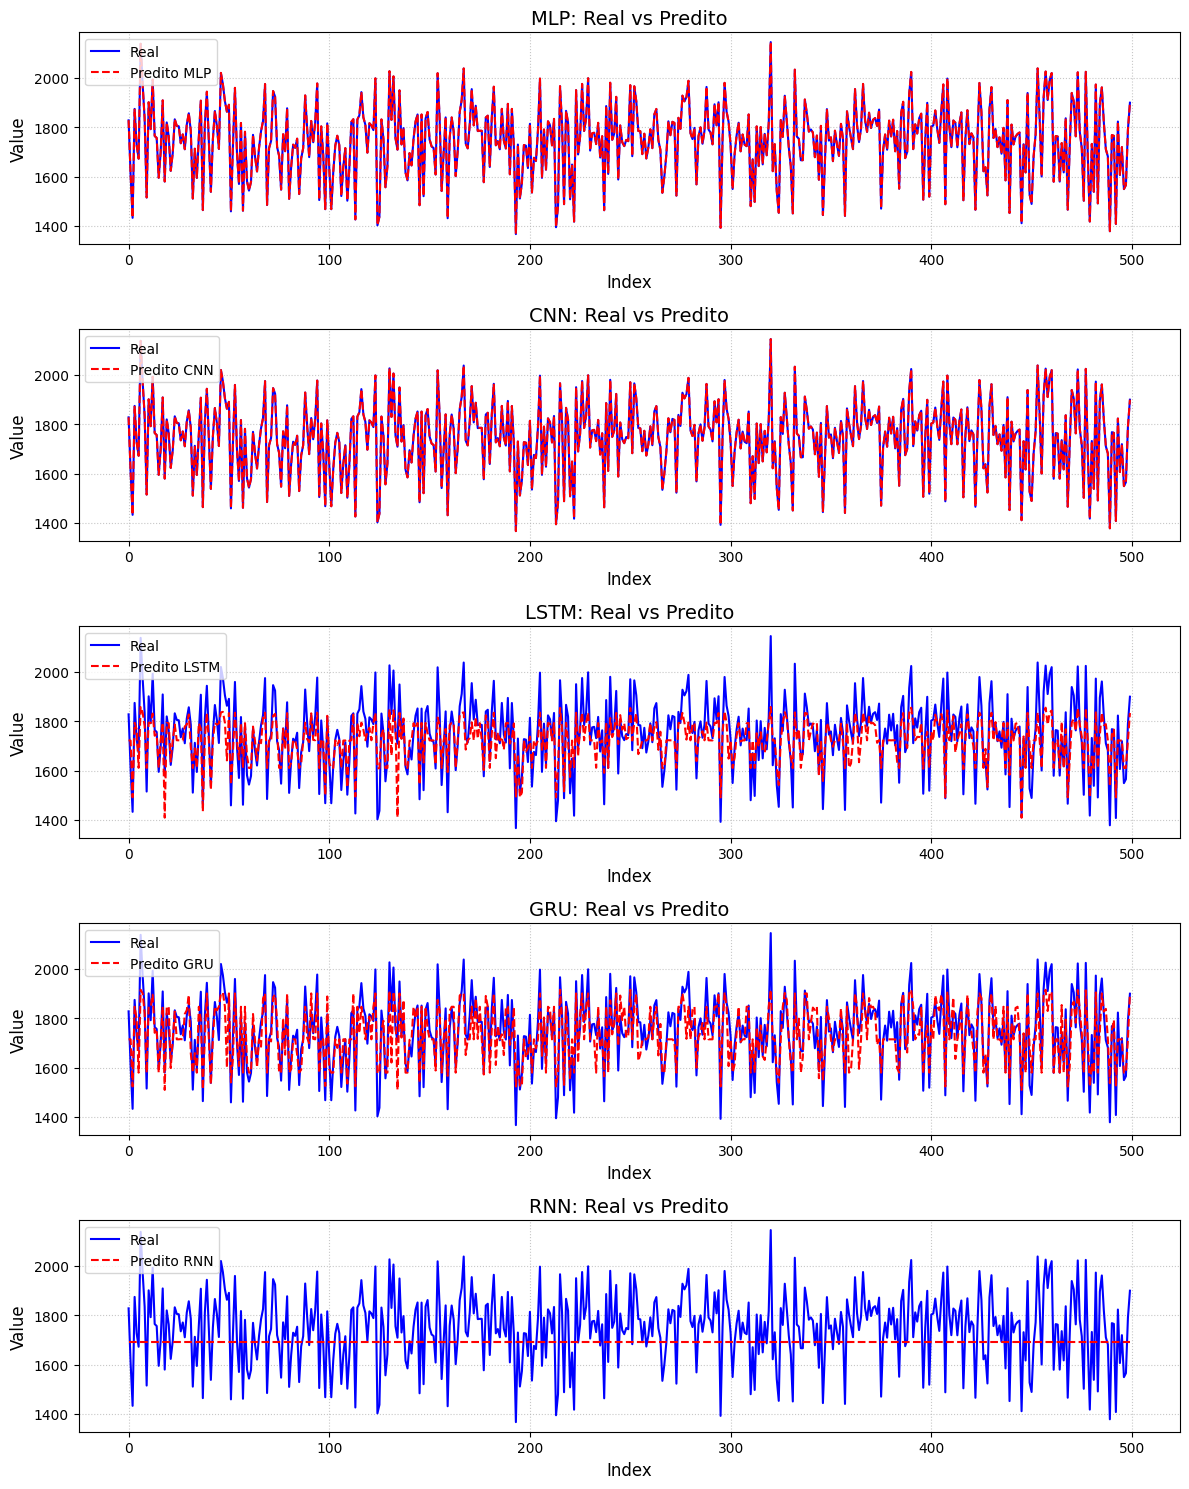


Gráficos gerados.


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, GRU, SimpleRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt # Importar Matplotlib


# Carregar dataset original completo
data_full = pd.read_csv('/content/oficialtcld0903.csv')  # Atualize o caminho se necessário

# --- MODIFICAÇÃO PARA USAR 20% DOS DADOS ---
# Definir a fração do dataset a ser utilizada
fraction_to_use = 0.20
num_rows_original = len(data_full)
num_rows_to_keep = int(num_rows_original * fraction_to_use)


# Opção 2: Pegar uma amostra aleatória de 20% das linhas (recomendado se a ordem não for crucial)
data = data_full.sample(frac=fraction_to_use).copy() # random_state para reprodutibilidade

print(f"Dataset original com {num_rows_original} linhas.")
print(f"Utilizando {len(data)} linhas ({fraction_to_use*100:.0f}% do original) para o processo de treino e teste.")
# --- FIM DA MODIFICAÇÃO ---

# Preparar X e y a partir do subset de dados
X = data.drop(columns=['med10','sd10'])
y = data['bal75']

# Resetar o índice é uma boa prática, especialmente se 'data.sample()' foi usado.
# Garante que .iloc na divisão treino/teste funcione como esperado (índices de 0 a N-1).
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Dividir os dados (do subset de 20%) em treino (70%) e teste (30%)
# A divisão continua sendo sequencial sobre o subset 'data'
split_percentage_train = 0.7 # 70% do subset para treino
split_index = int(len(X) * split_percentage_train)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Dos {len(X)} dados selecionados para o processo:")
print(f" - {len(X_train)} amostras para treino ({split_percentage_train*100:.0f}%)")
print(f" - {len(X_test)} amostras para teste ({(1-split_percentage_train)*100:.0f}%)")

# Modelos (definições originais)
def create_mlp_model(input_dim):
    model = Sequential([
        Dense(10, input_dim=input_dim, activation='relu'),
        Dense(5, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_cnn_model(input_dim):
    model = Sequential([
        Conv1D(10, 2, activation='relu', input_shape=(input_dim, 1)),
        Flatten(),
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_lstm_model(input_dim):
    model = Sequential([
        LSTM(10, input_shape=(input_dim, 1), activation='tanh'),
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model(input_dim):
    model = Sequential([
        GRU(10, input_shape=(input_dim, 1), activation='tanh'),
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_rnn_model(input_dim):
    model = Sequential([
        SimpleRNN(10, input_shape=(input_dim, 1), activation='tanh'),
        Dense(10, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Treinamento e avaliação (função levemente refatorada para aceitar dados como parâmetros)
def train_and_evaluate_model(model_name, model, X_train_data, y_train_data, X_test_data, y_test_data):
    if model_name in ['CNN', 'LSTM', 'GRU', 'RNN']:
        # Garante que .values seja chamado em DataFrames Pandas
        X_train_vals = X_train_data.values if isinstance(X_train_data, pd.DataFrame) else X_train_data
        X_test_vals = X_test_data.values if isinstance(X_test_data, pd.DataFrame) else X_test_data

        X_train_r = np.expand_dims(X_train_vals, axis=2)
        X_test_r = np.expand_dims(X_test_vals, axis=2)

        history = model.fit(X_train_r, y_train_data, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
        y_pred = model.predict(X_test_r).flatten()
    else: # MLP
        history = model.fit(X_train_data, y_train_data, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
        y_pred = model.predict(X_test_data).flatten()

    mae = mean_absolute_error(y_test_data, y_pred)
    mse = mean_squared_error(y_test_data, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} Model - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    return y_pred, rmse

# Treinar modelos
# A dimensão de entrada é baseada no shape de X_train (que agora é do subset)
input_dimension = X_train.shape[1]

mlp_model = create_mlp_model(input_dimension)
cnn_model = create_cnn_model(input_dimension)
lstm_model = create_lstm_model(input_dimension)
gru_model = create_gru_model(input_dimension)
rnn_model = create_rnn_model(input_dimension)

print("\nIniciando treinamento e avaliação dos modelos com 60% do dataset original...\n")

# Passar os dataframes de treino e teste explicitamente para a função
y_pred_mlp, rmse_mlp = train_and_evaluate_model("MLP", mlp_model, X_train, y_train, X_test, y_test)
y_pred_cnn, rmse_cnn = train_and_evaluate_model("CNN", cnn_model, X_train, y_train, X_test, y_test)
y_pred_lstm, rmse_lstm = train_and_evaluate_model("LSTM", lstm_model, X_train, y_train, X_test, y_test)
y_pred_gru, rmse_gru = train_and_evaluate_model("GRU", gru_model, X_train, y_train, X_test, y_test)
y_pred_rnn, rmse_rnn = train_and_evaluate_model("RNN", rnn_model, X_train, y_train, X_test, y_test)

print("\nTreinamento e avaliação concluídos.")

# --- INÍCIO DA SEÇÃO DE PLOTAGEM ---
print("\nGerando gráficos de Real vs. Predito...")

# Armazenar todas as previsões e nomes dos modelos para facilitar o loop
predictions = {
    "MLP": y_pred_mlp,
    "CNN": y_pred_cnn,
    "LSTM": y_pred_lstm,
    "GRU": y_pred_gru,
    "RNN": y_pred_rnn
}

model_names = ["MLP", "CNN", "LSTM", "GRU", "RNN"]

# Número de pontos a serem plotados (para não sobrecarregar o gráfico)
# Ajuste conforme necessário ou com base no tamanho de y_test
num_points_to_plot = min(500, len(y_test))

# y_test precisa ser um array numpy para slicing, se for uma Series Pandas, converta.
# No nosso caso, y_test já é uma Series, e o slicing funciona, mas para consistência:
y_test_plot = y_test.values[:num_points_to_plot] # Usar .values para garantir que é um array numpy
# Se y_test já foi reset_index e é uma Series, y_test[:num_points_to_plot] também funcionaria

# Criar a figura e os subplots
# 5 linhas, 1 coluna. Ajuste figsize para o tamanho desejado.
fig, axs = plt.subplots(len(model_names), 1, figsize=(12, 15), sharey=True) # sharey=True para mesma escala Y

if len(model_names) == 1: # Se houver apenas um modelo, axs não será uma lista
    axs = [axs]

for i, model_name in enumerate(model_names):
    ax = axs[i]
    y_pred_plot = predictions[model_name][:num_points_to_plot]

    indices = np.arange(num_points_to_plot) # Cria um array de 0 a num_points_to_plot-1 para o eixo x

    ax.plot(indices, y_test_plot, label='Real', color='blue', linewidth=1.5)
    ax.plot(indices, y_pred_plot, label=f'Predito {model_name}', color='red', linewidth=1.5, linestyle='--')

    ax.set_title(f'{model_name}: Real vs Predito', fontsize=14)
    ax.set_xlabel('Index', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.7)

    # Ajustar limites do eixo Y se necessário, ou deixar o Matplotlib decidir
    # Exemplo: ax.set_ylim([min_val, max_val])

plt.tight_layout() # Ajusta o espaçamento entre os subplots para evitar sobreposição
plt.show()

print("\nGráficos gerados.")
# --- FIM DA SEÇÃO DE PLOTAGEM ---